## Baseline Model
Uses a BiLSTM with pretrained GloVe embeddings(300 dimension).
The aspect term embedding is obtained and concatenated with the cell output of the BiLSTM layer. 

In [ ]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Colab Notebooks/CS4248/Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from collections import Counter

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence


from sklearn.metrics import classification_report,accuracy_score,f1_score,confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
sns.set()
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import spacy
import spacy.cli
spacy.cli.download('en_core_web_md')

nlp = spacy.load('en_core_web_md')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

## Load Glove Embeddings

In [ ]:
'''
Uncomment the following lines to download the GloVe 6B word embedding files.
The default location for download is the folder data/glove 
'''
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip -d ./data/glove
# !ls -lat ./data/glove

In [ ]:
WORD_EMBEDDING_SIZE=300

In [ ]:
class WordEmbeddings():
    def __init__(self,path):
        self.word2idx={'<pad>':0}
        self.idx2word=['<pad>']
        self.embeddings=[np.zeros(WORD_EMBEDDING_SIZE)]

        self.load_vectors(path)

    def load_vectors(self,path):
        with open(path,'r') as f:
            for idx,line in enumerate(f,start=len(self.embeddings)):
                values = line.split()
                word = values[0]
                vector = np.asarray(line.split()[1:],'float32')

                if word not in self.word2idx:
                    self.word2idx[word]=idx
                    self.idx2word.append(word)
                    self.embeddings.append(vector)
                
        self.embeddings = torch.tensor(np.array(self.embeddings))

        self.idx2word.append('<unk>')
        self.word2idx['<unk>'] = len(self.idx2word)-1
        self.embeddings = torch.cat((self.embeddings,self.embeddings.mean(dim=0).unsqueeze(0)),dim=0).float()

    def update_embeddings(self,new_terms):
        if new_terms in self.word2idx:
            return
        
        new_terms_list = new_terms.split()
        vector = [self.embeddings[self.word2idx[word]] if word in self.word2idx else self.embeddings[self.word2idx['<unk>']] for word in new_terms_list]
        vector = torch.stack(vector,dim=0)
        vector = torch.mean(vector,dim=0)
        self.idx2word.append(new_terms)
        self.word2idx[new_terms] = len(self.idx2word)-1

        self.embeddings = torch.cat((self.embeddings,vector.unsqueeze(0)),dim=0).float()
        return

vocab = WordEmbeddings(path='./data/glove/glove.6B.300d.txt')

## Load dataframe

In [ ]:
from ast import literal_eval

def split_string(text,delimiter=None):
    return literal_eval(text)

converters = {
    'AspectTerms':lambda x: literal_eval(x),
    'AspectTermsPolarity':lambda x: literal_eval(x),
    'TextWithPOS': lambda x:literal_eval(x),
    'FixedTextWithPOS': lambda x:literal_eval(x),
    'FixedTexttWithPOSReplaced': lambda x:literal_eval(x),
    'AspectTermsSpan': lambda x:literal_eval(x)
    }

In [ ]:
df = pd.read_csv('./data/pre_processed.csv',converters=converters)
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
df.head()

,ID,RawText,AspectTerms,AspectTermsPolarity,AspectTermsSpan,TextWithPOS,FixedTextWithPOS,Past,Future,Adj,Adv,Pronoun,Noun,Verb,Pos_lex,Neg_lex,FixedTexttWithPOSReplaced,TextWithIOB
0,3121,But the staff was so horrible to us.,[staff],[negative],"[(8, 13)]","[(But, CC), (the, DT), (staff, NN), (was, VBD)...","[(But, CC), (the, DT), (staff, NN), (be, VBD),...",1.0,0.000000,0.111111,0.111111,0.111111,0.111111,0.111111,0.00,0.50,"[(But, CC), (the, DT), (staff, NN), (be, VBD),...","[('But', 'O'), ('the', 'O'), ('staff', 'B-NP')..."
1,2777,"To be completely fair, the only redeeming fact...",[food],[positive],"[(57, 61)]","[(To, TO), (be, VB), (completely, RB), (fair, ...","[(To, TO), (be, VB), (completely, RB), (fair, ...",0.5,0.250000,0.096774,0.096774,0.000000,0.193548,0.129032,0.50,0.25,"[(To, TO), (be, VB), (completely, RB), (fair, ...","[('To', 'O'), ('be', 'O'), ('completely', 'O')..."
2,1634,"The food is uniformly exceptional, with a very...","[food, kitchen, menu]","[positive, positive, neutral]","[(4, 8), (55, 62), (141, 145)]","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[(The, DT), (food, NN), (be, VBZ), (uniformly,...",0.0,0.250000,0.096774,0.129032,0.064516,0.129032,0.129032,0.75,0.00,"[(The, DT), (food, NN), (be, VBZ), (uniformly,...","[('The', 'O'), ('food', 'B-NP'), ('is', 'O'), ..."
3,2534,Where Gabriela personaly greets you and recomm...,[],[],[],"[(Where, WRB), (Gabriela, NNP), (personal, JJ)...","[(Where, WRB), (Gabriela, NNP), (personal, JJ)...",0.0,0.000000,0.083333,0.000000,0.166667,0.166667,0.166667,0.50,0.00,"[(Where, WRB), (<PNOUN>, NNP), (personal, JJ),...","[('Where', 'O'), ('Gabriela', 'B-NP'), ('perso..."
4,583,"For those that go once and don't enjoy it, all...",[],[],[],"[(For, IN), (those, DT), (that, WDT), (go, VBP...","[(For, IN), (those, DT), (that, WDT), (go, VBP...",0.0,0.142857,0.000000,0.166667,0.166667,0.000000,0.291667,1.00,0.00,"[(For, IN), (those, DT), (that, WDT), (go, VBP...","[('For', 'O'), ('those', 'O'), ('that', 'O'), ..."


In [ ]:
def tokenizer(text,aspect_term,aspect_term_span):
    
    aspect_term = aspect_term.strip().lower()
    start,end = aspect_term_span
    start,end = int(start),int(end)

    left = text[:start].strip().lower()
    right = text[end+1:].strip().lower()

    doc_left = nlp(left)
    doc_right = nlp(right)

    tokens=[]
    tokens.extend(str(word) for word in doc_left if str(word)!='')
    tokens.append(aspect_term)
    tokens.extend(str(word) for word in doc_right if str(word)!='')

    return tokens

def pos_tagger(text):
    doc = nlp(text.lower())

    return [str(word.tag_) for word in doc]

def sentence2idx(tokens):
    return [vocab.word2idx[token] if token in vocab.word2idx else vocab.word2idx['<unk>'] for token in tokens]


In [ ]:
def plot_confusion_matrix(y_true,y_pred):
    mat = confusion_matrix(y_true, y_pred,labels=np.unique(y_true))
    sns.heatmap(mat, square = True, annot=True, fmt = "d", xticklabels=np.unique(y_true),yticklabels=np.unique(y_true),cmap='Blues')
    plt.xlabel("PREDICTED LABEL")
    plt.ylabel("TRUE LABEL")
    plt.show()

### Duplicate sentences for each aspect term

In [ ]:
def generate_dataset(df):
    rows_list=[]

    for idx,row in df.iterrows():
        for term_idx,term in enumerate(row['AspectTerms']):
            new_row = list(row[~df.columns.isin(['AspectTerms', 'AspectTermsPolarity', 'AspectTermsSpan'])])
            new_row.insert(2,term)
            new_row.insert(3,row['AspectTermsPolarity'][term_idx])
            new_row.insert(4,row['AspectTermsSpan'][term_idx])
            rows_list.append(new_row)
            

    new_df=pd.DataFrame(rows_list,columns=df.columns.tolist())
    new_df['AspectTerms'] = new_df['AspectTerms'].apply(str.lower)
    
    return new_df

In [ ]:
review_df = generate_dataset(df)
review_df = review_df[review_df['AspectTermsPolarity']!='conflict']


In [ ]:
review_df['tokens'] = review_df.apply(lambda x: tokenizer(x['RawText'],x['AspectTerms'],x['AspectTermsSpan']),axis=1)


In [ ]:
review_df.apply(lambda x: vocab.update_embeddings(x['AspectTerms']),axis=1)
print('')

In [ ]:
max_length = max(review_df['tokens'].apply(len))

In [ ]:
print(max_length)

79


In [ ]:
le = LabelEncoder()

review_df['encoded_polarity_labels'] = le.fit_transform(review_df['AspectTermsPolarity'])


In [ ]:
review_df.head()

,ID,RawText,AspectTerms,AspectTermsPolarity,AspectTermsSpan,TextWithPOS,FixedTextWithPOS,Past,Future,Adj,Adv,Pronoun,Noun,Verb,Pos_lex,Neg_lex,FixedTexttWithPOSReplaced,TextWithIOB,tokens,encoded_polarity_labels
0,3121,But the staff was so horrible to us.,staff,negative,"(8, 13)","[(But, CC), (the, DT), (staff, NN), (was, VBD)...","[(But, CC), (the, DT), (staff, NN), (be, VBD),...",1.0,0.00,0.111111,0.111111,0.111111,0.111111,0.111111,0.00,0.50,"[(But, CC), (the, DT), (staff, NN), (be, VBD),...","[('But', 'O'), ('the', 'O'), ('staff', 'B-NP')...","[but, the, staff, was, so, horrible, to, us, .]",0
1,2777,"To be completely fair, the only redeeming fact...",food,positive,"(57, 61)","[(To, TO), (be, VB), (completely, RB), (fair, ...","[(To, TO), (be, VB), (completely, RB), (fair, ...",0.5,0.25,0.096774,0.096774,0.000000,0.193548,0.129032,0.50,0.25,"[(To, TO), (be, VB), (completely, RB), (fair, ...","[('To', 'O'), ('be', 'O'), ('completely', 'O')...","[to, be, completely, fair, ,, the, only, redee...",2
2,1634,"The food is uniformly exceptional, with a very...",food,positive,"(4, 8)","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[(The, DT), (food, NN), (be, VBZ), (uniformly,...",0.0,0.25,0.096774,0.129032,0.064516,0.129032,0.129032,0.75,0.00,"[(The, DT), (food, NN), (be, VBZ), (uniformly,...","[('The', 'O'), ('food', 'B-NP'), ('is', 'O'), ...","[the, food, is, uniformly, exceptional, ,, wit...",2
3,1634,"The food is uniformly exceptional, with a very...",kitchen,positive,"(55, 62)","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[(The, DT), (food, NN), (be, VBZ), (uniformly,...",0.0,0.25,0.096774,0.129032,0.064516,0.129032,0.129032,0.75,0.00,"[(The, DT), (food, NN), (be, VBZ), (uniformly,...","[('The', 'O'), ('food', 'B-NP'), ('is', 'O'), ...","[the, food, is, uniformly, exceptional, ,, wit...",2
4,1634,"The food is uniformly exceptional, with a very...",menu,neutral,"(141, 145)","[(The, DT), (food, NN), (is, VBZ), (uniformly,...","[(The, DT), (food, NN), (be, VBZ), (uniformly,...",0.0,0.25,0.096774,0.129032,0.064516,0.129032,0.129032,0.75,0.00,"[(The, DT), (food, NN), (be, VBZ), (uniformly,...","[('The', 'O'), ('food', 'B-NP'), ('is', 'O'), ...","[the, food, is, uniformly, exceptional, ,, wit...",1


### Generate POS tag to idx and idx to POS tag dict

In [ ]:
pos2idx={'<pad>':0}
idx2pos=['<pad>']

In [ ]:
def update_pos_dict(pos_tags_list):
    pos_idx=1
    for idx,pos_tags in pos_tags_list.iteritems():
        for tag in pos_tags:
            if tag not in pos2idx:
                pos2idx[tag]=pos_idx
                idx2pos.append(tag)
                pos_idx+=1

### Pytorch Dataset instance 

In [ ]:
class ReviewData(Dataset):
    def __init__(self,tokens,aspect_term,aspect_polarity):
        self.tokens=tokens
        self.aspect_term=aspect_term
        self.aspect_polarity = aspect_polarity

    def __len__(self):
        return len(self.aspect_polarity)

    def __getitem__(self, idx):
        sentence_idx = torch.tensor(sentence2idx(self.tokens[idx]),dtype=torch.long)
        aspect_idx = torch.tensor(sentence2idx([self.aspect_term[idx]]),dtype=torch.long)
        
        aspect_polarity = torch.tensor(self.aspect_polarity[idx],dtype=torch.long)
        return (sentence_idx,aspect_idx,aspect_polarity)

def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    lens = [len(x[0])for x in batch]
    aspect_lens = [len(x[1])for x in batch]
    
    padded = pad_sequence([x[0] for x in batch],batch_first=True)
    terms_list = pad_sequence([x[1] for x in batch],batch_first=True)
    polarity_list = torch.stack([x[2] for x in batch])
    
    return padded,terms_list,polarity_list,lens,aspect_lens

### Train and test sets

In [ ]:
label_counts = review_df['AspectTermsPolarity'].value_counts()
dict(label_counts)


{'negative': 807, 'neutral': 637, 'positive': 2164}

In [ ]:
train_df,val_df = train_test_split(review_df, test_size=0.3, random_state=42,stratify=review_df['encoded_polarity_labels'])

In [ ]:
train_dataset = ReviewData(train_df['tokens'].values,train_df['AspectTerms'].values,train_df['encoded_polarity_labels'].values)
val_dataset = ReviewData(val_df['tokens'].values,val_df['AspectTerms'].values,val_df['encoded_polarity_labels'].values)

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_loader = DataLoader(train_dataset,collate_fn=collate_fn,batch_size=BATCH_SIZE,drop_last=False,shuffle=True,worker_init_fn=seed_worker,
    generator=g)

In [ ]:
val_loader = DataLoader(val_dataset,collate_fn=collate_fn,batch_size=BATCH_SIZE,drop_last=False,shuffle=False,worker_init_fn=seed_worker,
    generator=g)

In [ ]:
for a,b,c,d,e in train_loader:
    print(a.size(),b.size(),c.size())
    break

torch.Size([32, 38]) torch.Size([32, 1]) torch.Size([32])


### BiLSTM

In [ ]:
from torch.nn.modules.activation import Softmax
class Encoder(nn.Module):
    def __init__(self,input_size,pos_size,hidden_size,output_size,max_len,p=0.2,bidirectional=False,pretrained=True):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.pos_size = pos_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.p = p
        self.max_len = max_len
        
        
        if pretrained==False:
            self.embedding = nn.Embedding(self.input_size,self.hidden_size)
        else:
            self.embedding =  nn.Embedding.from_pretrained(vocab.embeddings,freeze=False)
        

        self.sentence_encoder = nn.LSTM(self.hidden_size,self.hidden_size,bidirectional=bidirectional,batch_first=True)

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * self.hidden_size + self.hidden_size, self.hidden_size),
            nn.Tanh(),
            nn.Linear(self.hidden_size, 1)
        )

        self.r_transform = nn.Sequential(
            nn.Linear(2*self.hidden_size,self.hidden_size),
            nn.ReLU()
        )
        self.h_transform = nn.Sequential(
            nn.Linear(2*self.hidden_size,self.hidden_size),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=self.p),
            nn.Linear(self.hidden_size,self.output_size),
        )
        

        self.dropout = nn.Dropout(p=self.p)
        

    def forward(self,x,aspect_terms,lens,aspect_lens,h,c):

        sentence_embedding = self.embedding(x)
        aspect_embedding = self.embedding(aspect_terms)

        pack_sent_embedding = pack_padded_sequence(sentence_embedding,batch_first=True,enforce_sorted=True,lengths=lens)

        sentence_enc,(h,c) = self.sentence_encoder(pack_sent_embedding)

        sentence_enc,_ = pad_packed_sequence(sentence_enc,batch_first=True)

        aspect_repeated = aspect_embedding.repeat(1,sentence_embedding.size(1),1)
        sentence_cat = torch.cat((sentence_enc,aspect_repeated),dim=2)

       
        attention_score = self.attn_layer(sentence_cat) # alpha(B,N,1) without softmax

        alpha = torch.softmax(attention_score.permute(0,2,1),dim=1)

        r = torch.bmm(alpha,sentence_enc) # H*alpha_T


        r_t = self.r_transform(r).squeeze(1)
        
        h_t = self.h_transform(sentence_enc[:, -1, :])
        

        h_star = torch.tanh(r_t+h_t)
        h_star = self.dropout(h_star)
        
        out = self.classifier(h_star)

        return out,(h,c)



    def initHidden(self):
        return torch.zeros(2, BATCH_SIZE, self.hidden_size, device=device)

### Plots

In [ ]:
def plot_data(x_1,x_2,x_label,y_label,title):
    plt.plot(x_1)
    plt.plot(x_2)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### Evaluate model

In [ ]:
def evaluate(model,loader):
    model.eval()
    test_loss = 0
    total = 0
    labels=[]
    preds=[]
    with torch.no_grad():
        h = model.initHidden()
        c = model.initHidden()
        for x,aspect_terms,aspect_polarity,lens,aspect_lens in loader:
            
            x = x.to(device)
            aspect_polarity = aspect_polarity.to(device)
            aspect_terms = aspect_terms.to(device)

 
            out,(h,c) = model(x,aspect_terms,lens,aspect_lens,h,c)
            loss = criterion(out,aspect_polarity)

            test_loss += (loss.detach().item())
            total+=1

            labels.extend(aspect_polarity.cpu())
            preds.extend(torch.argmax(out,dim=1).cpu())

    val_f1 = f1_score(labels,preds,average='macro')
    val_acc = accuracy_score(labels,preds)

    print('\t\tEval Loss: {:.6f} \tAccuracy:{:.6f} \tF1: {:.6f}\n'.format(test_loss/total,accuracy_score(labels,preds),val_f1))
    total_loss = test_loss/total
    return total_loss,val_acc,labels,preds

### Train

In [ ]:
model = Encoder(vocab.embeddings.size(0),len(pos2idx),vocab.embeddings.size(1),len(label_counts),max_length,p=0.2,bidirectional=True,pretrained=True).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=3e-4)
criterion = nn.CrossEntropyLoss().to(device)

NameError: ignored

In [ ]:
NUM_EPOCHS = 6

In [ ]:
def train(model=None):

    if model is None:
        model = Encoder(vocab.embeddings.size(0),len(pos2idx),vocab.embeddings.size(1),len(label_counts),max_length,p=0.5,bidirectional=True,pretrained=True).to(device)
    train_loss_list=[]
    val_loss_list=[]
    train_acc_list=[]
    val_acc_list=[]

    for i in range(NUM_EPOCHS):

        model.train()
        samples=[]
        preds=[]
        running_loss=0
        num_batches=0
        h = model.initHidden()
        c = model.initHidden()

        for x,aspect_terms,aspect_polarity,lens,aspect_lens in train_loader:

            x = x.to(device)
            aspect_polarity = aspect_polarity.to(device)
            aspect_terms = aspect_terms.to(device)

            optimizer.zero_grad()
            out,(h,c) = model(x,aspect_terms,lens,aspect_lens,h,c)
            loss = criterion(out,aspect_polarity)

            loss.backward()
            running_loss+=loss.detach().item()
            optimizer.step()
            
            num_batches+=1

            samples.extend(aspect_polarity.cpu())
            preds.extend(torch.argmax(out,dim=1).cpu())

        total_loss = running_loss/num_batches
        train_loss_list.append(total_loss)

        train_acc = accuracy_score(samples,preds)
        train_acc_list.append(train_acc)
        train_f1 = f1_score(samples,preds,average='macro')

        print('Epoch: {} \tTrain Loss: {:.6f} \tAccuracy: {:.6f} \tF1: {:.6f}'.format(i+1, total_loss,train_acc,train_f1))
        val_loss,val_acc,_,_ = evaluate(model,val_loader)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    plot_data(train_loss_list,val_loss_list,'epoch','loss','model loss')
    plot_data(train_acc_list,val_acc_list,'epoch','accuracy','model accuracy')
    return model

Epoch: 1 	Train Loss: 0.876623 	Accuracy: 0.612277 	F1: 0.360408
		Eval Loss: 0.764710 	Accuracy:0.658356 	F1: 0.481314

Epoch: 2 	Train Loss: 0.711229 	Accuracy: 0.694257 	F1: 0.551368
		Eval Loss: 0.693511 	Accuracy:0.714681 	F1: 0.566983

Epoch: 3 	Train Loss: 0.617897 	Accuracy: 0.744950 	F1: 0.642081
		Eval Loss: 0.685312 	Accuracy:0.710988 	F1: 0.570873

Epoch: 4 	Train Loss: 0.550841 	Accuracy: 0.778614 	F1: 0.688212
		Eval Loss: 0.691478 	Accuracy:0.704524 	F1: 0.576130

Epoch: 5 	Train Loss: 0.485020 	Accuracy: 0.810693 	F1: 0.732600
		Eval Loss: 0.712313 	Accuracy:0.706371 	F1: 0.592666

Epoch: 6 	Train Loss: 0.442791 	Accuracy: 0.830099 	F1: 0.766282
		Eval Loss: 0.758825 	Accuracy:0.707295 	F1: 0.604798



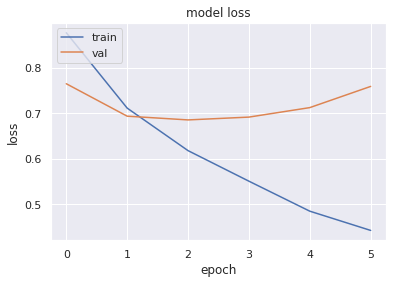

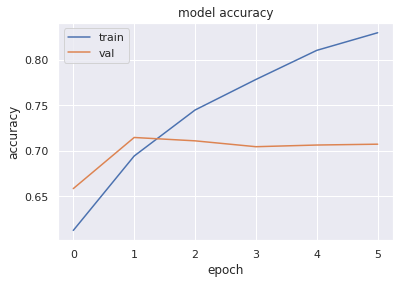

In [ ]:
model = train(model)

		Eval Loss: 0.758825 	Accuracy:0.707295 	F1: 0.604798



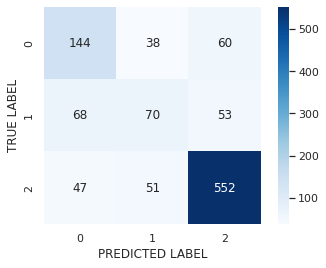

In [ ]:
_,_,labels,preds = evaluate(model,val_loader)
    
plot_confusion_matrix(labels,preds)

## Test data

In [ ]:
test_df = pd.read_csv('./data/pre_processed_test.csv',converters=converters)
test_df.head()

,ID,RawText,AspectTerms,AspectTermsPolarity,AspectTermsSpan,RawTextTokenize,RawTextWithLabelIOB,TextWithPOS,TextWithPOSReplaced
0,32897564#894393#2,The bread is top notch as well.,[bread],[positive],"[(4, 9)]","['The', 'bread', 'is', 'top', 'notch', 'as', '...","[('The', 'O', None), ('bread', 'B', 'positive'...","[(The, DT), (bread, NN), (is, VBZ), (top, JJ),...","[('The', 'DT'), ('bread', 'NN'), ('is', 'VBZ')..."
1,33070600#670328#0,I have to say they have one of the fastest del...,[delivery times],[positive],"[(43, 57)]","['I', 'have', 'to', 'say', 'they', 'have', 'on...","[('I', 'O', None), ('have', 'O', None), ('to',...","[(I, PRP), (have, VBP), (to, TO), (say, VB), (...","[('I', 'PRP'), ('have', 'VBP'), ('to', 'TO'), ..."
2,33070600#670328#2,Food is always fresh and hot- ready to eat!,[Food],[positive],"[(0, 4)]","['Food', 'is', 'always', 'fresh', 'and', 'hot-...","[('Food', 'B', 'positive'), ('is', 'O', None),...","[(Food, NN), (is, VBZ), (always, RB), (fresh, ...","[('Food', 'NN'), ('is', 'VBZ'), ('always', 'RB..."
3,36244464#949326#5,Did I mention that the coffee is OUTSTANDING?,[coffee],[positive],"[(23, 29)]","['Did', 'I', 'mention', 'that', 'the', 'coffee...","[('Did', 'O', None), ('I', 'O', None), ('menti...","[(Did, NNP), (I, PRP), (mention, NN), (that, I...","[('<PNOUN>', 'NNP'), ('I', 'PRP'), ('mention',..."
4,32894246#870052#0,"Certainly not the best sushi in New York, howe...","[sushi, place]","[conflict, positive]","[(23, 28), (79, 84)]","['Certainly', 'not', 'the', 'best', 'sushi', '...","[('Certainly', 'O', None), ('not', 'O', None),...","[(Certainly, RB), (not, RB), (the, DT), (best,...","[('Certainly', 'RB'), ('not', 'RB'), ('the', '..."


In [ ]:
review_test_df = generate_dataset(test_df)
review_test_df = review_test_df[review_test_df['AspectTermsPolarity']!='conflict']

In [ ]:
review_test_df['tokens'] = review_test_df.apply(lambda x: tokenizer(x['RawText'],x['AspectTerms'],x['AspectTermsSpan']),axis=1)

In [ ]:
le = LabelEncoder()

review_test_df['encoded_polarity_labels'] = le.fit_transform(review_test_df['AspectTermsPolarity'])


In [ ]:
review_test_df.head()

,ID,RawText,AspectTerms,AspectTermsPolarity,AspectTermsSpan,RawTextTokenize,RawTextWithLabelIOB,TextWithPOS,TextWithPOSReplaced,tokens,encoded_polarity_labels
0,32897564#894393#2,The bread is top notch as well.,bread,positive,"(4, 9)","['The', 'bread', 'is', 'top', 'notch', 'as', '...","[('The', 'O', None), ('bread', 'B', 'positive'...","[(The, DT), (bread, NN), (is, VBZ), (top, JJ),...","[('The', 'DT'), ('bread', 'NN'), ('is', 'VBZ')...","[the, bread, is, top, notch, as, well, .]",2
1,33070600#670328#0,I have to say they have one of the fastest del...,delivery times,positive,"(43, 57)","['I', 'have', 'to', 'say', 'they', 'have', 'on...","[('I', 'O', None), ('have', 'O', None), ('to',...","[(I, PRP), (have, VBP), (to, TO), (say, VB), (...","[('I', 'PRP'), ('have', 'VBP'), ('to', 'TO'), ...","[i, have, to, say, they, have, one, of, the, f...",2
2,33070600#670328#2,Food is always fresh and hot- ready to eat!,food,positive,"(0, 4)","['Food', 'is', 'always', 'fresh', 'and', 'hot-...","[('Food', 'B', 'positive'), ('is', 'O', None),...","[(Food, NN), (is, VBZ), (always, RB), (fresh, ...","[('Food', 'NN'), ('is', 'VBZ'), ('always', 'RB...","[food, is, always, fresh, and, hot-, ready, to...",2
3,36244464#949326#5,Did I mention that the coffee is OUTSTANDING?,coffee,positive,"(23, 29)","['Did', 'I', 'mention', 'that', 'the', 'coffee...","[('Did', 'O', None), ('I', 'O', None), ('menti...","[(Did, NNP), (I, PRP), (mention, NN), (that, I...","[('<PNOUN>', 'NNP'), ('I', 'PRP'), ('mention',...","[did, i, mention, that, the, coffee, is, outst...",2
5,32894246#870052#0,"Certainly not the best sushi in New York, howe...",place,positive,"(79, 84)","['Certainly', 'not', 'the', 'best', 'sushi', '...","[('Certainly', 'O', None), ('not', 'O', None),...","[(Certainly, RB), (not, RB), (the, DT), (best,...","[('Certainly', 'RB'), ('not', 'RB'), ('the', '...","[certainly, not, the, best, sushi, in, new, yo...",2


In [ ]:
test_dataset = ReviewData(review_test_df['tokens'].values,review_test_df['AspectTerms'].values,review_test_df['encoded_polarity_labels'].values)

In [ ]:
test_loader = DataLoader(test_dataset,collate_fn=collate_fn,batch_size=BATCH_SIZE,drop_last=False,shuffle=False,worker_init_fn=seed_worker,
    generator=g)

		Eval Loss: 0.640435 	Accuracy:0.761607 	F1: 0.641380



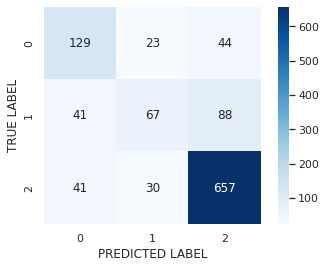

Macro F1:  0.6413801744150618
Weighted F1:  0.7481616383708078
Accuracy:  0.7616071428571428
(0.6674691202293782, 0.6341575091575091, 0.6413801744150618, None)


In [ ]:
_,_,labels,preds = evaluate(model,test_loader)
    
plot_confusion_matrix(labels,preds)
print('Macro F1: ',f1_score(labels,preds,average='macro'))
print('Weighted F1: ',f1_score(labels,preds,average='weighted'))
print('Accuracy: ',accuracy_score(labels,preds))

print(precision_recall_fscore_support(labels,preds,average='macro'))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# torch.save(model,'baseline_with_attention.pt')

### Evaluate and print classification report

In [ ]:
test_model = torch.load('./baseline_with_attention.pt',map_location=torch.device('cpu'))
test_model.eval()

In [ ]:
criterion = nn.CrossEntropyLoss()
_,_,labels,preds = evaluate(test_model,val_loader)
_,cats = pd.factorize(val_df['AspectTermsPolarity'],sort=True)

print(classification_report(labels,preds,target_names=cats))

		Eval Loss: 0.758825 	Accuracy:0.707295 	F1: 0.604798

              precision    recall  f1-score   support

    negative       0.56      0.60      0.57       242
     neutral       0.44      0.37      0.40       191
    positive       0.83      0.85      0.84       650

    accuracy                           0.71      1083
   macro avg       0.61      0.60      0.60      1083
weighted avg       0.70      0.71      0.70      1083



### Test with sample inputs

In [ ]:
test_samples = review_test_df.sample(10)
test_samples

,ID,RawText,AspectTerms,AspectTermsPolarity,AspectTermsSpan,RawTextTokenize,RawTextWithLabelIOB,TextWithPOS,TextWithPOSReplaced
574,32891589#573560#1,They have wheat crusted pizza made with really...,ingredients,positive,"(63, 74)","['They', 'have', 'wheat', 'crusted', 'pizza', ...","[('They', 'O', None), ('have', 'O', None), ('w...","[(They, PRP), (have, VBP), (wheat, VBN), (crus...","[('They', 'PRP'), ('have', 'VBP'), ('wheat', '..."
922,11351741#1733901#0,I went for restaurant week and ordered off the...,prix fixe menu,neutral,"(47, 61)","['I', 'went', 'for', 'restaurant', 'week', 'an...","[('I', 'O', None), ('went', 'O', None), ('for'...","[(I, PRP), (went, VBD), (for, IN), (restaurant...","[('I', 'PRP'), ('went', 'VBD'), ('for', 'IN'),..."
725,35743460#0#3,Offerings like hot cakes and the Egg McMuffin ...,breakfast,neutral,"(73, 82)","['Offerings', 'like', 'hot', 'cakes', 'and', '...","[('Offerings', 'O', None), ('like', 'O', None)...","[(Offerings, NNS), (like, IN), (hot, JJ), (cak...","[('Offerings', 'NNS'), ('like', 'IN'), ('hot',..."
258,11359767#969393#2,"The food was great - sushi was good, but the c...",cooked food,positive,"(45, 56)","['The', 'food', 'was', 'great', '-', 'sushi', ...","[('The', 'O', None), ('food', 'B', 'positive')...","[(The, DT), (food, NN), (was, VBD), (great, JJ...","[('The', 'DT'), ('food', 'NN'), ('was', 'VBD')..."
105,32938828#1194079#1,The food is great and the milkshakes are even ...,food,positive,"(4, 8)","['The', 'food', 'is', 'great', 'and', 'the', '...","[('The', 'O', None), ('food', 'B', 'positive')...","[(The, DT), (food, NN), (is, VBZ), (great, JJ)...","[('The', 'DT'), ('food', 'NN'), ('is', 'VBZ'),..."
1087,32894966#1727613#3,"While the smoothies are a little big for me, t...",fresh juices,positive,"(49, 61)","['While', 'the', 'smoothies', 'are', 'a', 'lit...","[('While', 'O', None), ('the', 'O', None), ('s...","[(While, IN), (the, DT), (smoothies, NNS), (ar...","[('While', 'IN'), ('the', 'DT'), ('smoothies',..."
511,35177381#521555#1,Our waitress had apparently never tried any of...,waitress,negative,"(4, 12)","['Our', 'waitress', 'had', 'apparently', 'neve...","[('Our', 'O', None), ('waitress', 'B', 'negati...","[(Our, PRP$), (waitress, NN), (had, VBD), (app...","[('Our', 'PRP$'), ('waitress', 'NN'), ('had', ..."
23,11359717#1138929#4,"menu - uneventful, small.",menu,negative,"(0, 4)","['menu', '-', 'uneventful', ',', 'small', '.']","[('menu', 'B', 'negative'), ('-', 'O', None), ...","[(menu, SYM), (-, :), (uneventful, JJ), (,, ,)...","[('menu', 'SYM'), ('-', ':'), ('uneventful', '..."
596,35509422#0#3,"Generously garnished, organic grilled burgers ...",dish,positive,"(67, 71)","['Generously', 'garnished', ',', 'organic', 'g...","[('Generously', 'O', None), ('garnished', 'O',...","[(Generously, RB), (garnished, VBN), (,, ,), (...","[('Generously', 'RB'), ('garnished', 'VBN'), (..."
665,11313359#650269#5,The boutique selection of wines covers a wide ...,boutique selection of wines,neutral,"(4, 31)","['The', 'boutique', 'selection', 'of', 'wines'...","[('The', 'O', None), ('boutique', 'B', 'neutra...","[(The, DT), (boutique, NN), (selection, NN), (...","[('The', 'DT'), ('boutique', 'NN'), ('selectio..."


In [ ]:
def test(sentence,aspects,spans):

    input=[]
    y=[]

    labels={0:'negative',1:'neutral',2:'positive'}
   
    for idx,aspect in enumerate(aspects):
        
        input.append((sentence,aspect,spans[idx]))

    for x,aspect,span in input:

        x_tokens = tokenizer(x,aspect,span)
        x_len=[len(x_tokens)]
        x_tokens = sentence2idx(x_tokens)
        x_tokens = torch.tensor(x_tokens,dtype=torch.long).unsqueeze(0).to(device)

        x_aspect = sentence2idx([aspect])
        x_aspect = torch.tensor(x_aspect,dtype=torch.long).unsqueeze(0).to(device)

        out,(h,c) = test_model(x_tokens,x_aspect,x_len,[1],None,None)
        
        y_pred = torch.argmax(out,dim=1).item()

        print('Sentence: {}\n Aspect: {}\n Predicted polarity: {}\n'.format(x,aspect,labels[y_pred]))


        



In [ ]:
for idx,row in test_samples.iterrows():
    test(row['RawText'],[row['AspectTerms']],[row['AspectTermsSpan']])
    print(' Actual: ',row['AspectTermsPolarity'])
    print('\n')

Sentence: They have wheat crusted pizza made with really fresh and yummy ingredients.
 Aspect: ingredients
 Predicted polarity: positive
 Actual:  positive


Sentence: I went for restaurant week and ordered off the prix fixe menu
 Aspect: prix fixe menu
 Predicted polarity: neutral
 Actual:  neutral


Sentence: Offerings like hot cakes and the Egg McMuffin sandwich are available for breakfast.
 Aspect: breakfast
 Predicted polarity: neutral
 Actual:  neutral


Sentence: The food was great - sushi was good, but the cooked food amazed us.
 Aspect: cooked food
 Predicted polarity: positive
 Actual:  positive


Sentence: The food is great and the milkshakes are even better!
 Aspect: food
 Predicted polarity: positive
 Actual:  positive


Sentence: While the smoothies are a little big for me, the fresh juices are the best I have ever had!
 Aspect: fresh juices
 Predicted polarity: positive
 Actual:  positive


Sentence: Our waitress had apparently never tried any of the food, and there was 